![alternative text](../../data/forward_chatgpt.png)
![alternative text](../../data/grad_chatgpt.png)

In this notebook we're going to solve a neural network using pytorch tensors. We'll write our own backpropagation for a simple fully-connected network. 

In [1]:
import numpy as np
from matplotlib.pylab import plt
import torch
import torch.nn as nn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import random

In [22]:

class CustomLinearLayer(nn.Module):
    
    def __init__(self, input_size, output_size):
        super(CustomLinearLayer, self).__init__()
        self.weight = torch.tensor(self.xavier_normal_init(input_size, output_size),dtype=torch.float32, requires_grad=False)
        self.bias = torch.zeros(output_size,dtype=torch.float32, requires_grad=False)
        
    def forward(self, x):
        return torch.matmul(x,self.weight) + self.bias
    
    def xavier_normal_init(self, input_units, output_units):
        # Calculate the standard deviation for Xavier initialization
        std_dev = np.sqrt(2 / (input_units + output_units))

        # Initialize weights with random values drawn from a normal distribution
        weights = np.random.normal(0, std_dev, (output_units, input_units))

        return weights.T

class ModelHelper():
    
    '''
     Utilities for applying process to neural network for training and testing 
    '''
    
    def __init__(self, linear_layers= None):
        self.linear_layers = linear_layers
        
    # Sigmoid activation function
    def sigmoid(self, x):
        return 1 / (1 + torch.exp(-x))

    def relu(self, x):
        return torch.max(torch.tensor(0.0), x)

    # relu derivative
    def relu_derivative(self,x):
        gradient = torch.zeros_like(x)
        gradient[x > 0] = 1
        return gradient

    # Sigmoid derivative
    def sigmoid_derivative(self,x):
        return x * (1 - x)

    def clip_gradient(self,param , max_gradient_norm = 20):
        '''
        clipping parameters range
        '''
        param_norm = param.norm(2)
        total_norm  = (param_norm ** 2).sum()**0.5
        if total_norm > max_gradient_norm:
            scale_factor = max_gradient_norm / (total_norm + 1e-6)  # Small epsilon to avoid division by zero
            param *= scale_factor
            
        return param

    def update_layer(self, linear_layer, hidden_output, delta_output,X,learning_rate):
        '''
        update weights and biases 
        '''
        
        dw = (torch.matmul(hidden_output.T, delta_output)/len(X))
        linear_layer.weight += dw * learning_rate
        linear_layer.weight  = self.clip_gradient(linear_layer.weight)

        db = (torch.sum(delta_output, dim=0, keepdim=True).squeeze()/len(X))
        linear_layer.bias   +=  db * learning_rate
        linear_layer.bias    = self.clip_gradient(linear_layer.bias)
        
        return linear_layer

    def grad(self, linear_layer, delta_output, hidden_output, activation='relu' ):
        if activation   == 'relu':
            delta  = torch.matmul(delta_output, linear_layer.weight.T)* self.relu_derivative(hidden_output)

        elif activation == 'sigmoid':
            delta  = torch.matmul(delta_output, linear_layer.weight.T)* self.sigmoid_derivative(hidden_output)

        return delta
    
    def model(self, x_test):
        
        hidden_input  = self.linear_layers[0].forward(x_test)
        hidden_output = self.relu(hidden_input)
        hidden_output = self.linear_layers[1].forward(hidden_output)
        hidden_output = self.relu(hidden_output)
        hidden_output = self.linear_layers[2].forward(hidden_output)
        hidden_output = self.relu(hidden_output)
        hidden_output = self.linear_layers[3].forward(hidden_output)
        predicted_output = self.sigmoid(hidden_output)

        return predicted_output
    
    def plot_decision_boundary(self, X, Y):
        plt.figure(figsize=(8, 6))
        h = .02  # Step size in the mesh
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 500), torch.linspace(y_min, y_max, 500))

        mesh_data = torch.cat((xx.flatten().unsqueeze(1), yy.flatten().unsqueeze(1)), dim=1)

        Z = self.model(mesh_data).detach().numpy()
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.5)
        plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)

        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('Decision Boundary')
        plt.show()

    
class Dataset():
    '''
    Create one of Logic gate datasets : XOR, XNOR, AND or 2 feature synthetic dataset
    '''
    def __init__(self, dataset_name = 'XOR'):
        self.dataset_name = dataset_name
        
    def make_dataset(self):
        n_features = 2

        if self.dataset_name == "XOR":
            X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
            Y = np.array([[0], [1], [1], [0]])

        elif self.dataset_name == "AND":
            X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
            Y = np.array([[0], [0], [0], [1]]) 

        elif self.dataset_name == "XNOR":
            X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
            Y = np.array([[1], [0], [0], [1]]) 

        elif self.dataset_name == "SYN":
            num_samples_per_class = 1000

            # Class 0 data (centered at (2, 2))
            class_0_x = np.random.normal(2, 1, num_samples_per_class)
            class_0_y = np.random.normal(2, 1, num_samples_per_class)
            class_0_labels = np.zeros(num_samples_per_class)

            # Class 1 data (centered at (5, 5))
            class_1_x = np.random.normal(5, 1, num_samples_per_class)
            class_1_y = np.random.normal(5, 1, num_samples_per_class)
            class_1_labels = np.ones(num_samples_per_class)

            # Concatenate the data
            X = np.vstack((np.column_stack((class_0_x, class_0_y)), np.column_stack((class_1_x, class_1_y))))
            Y = np.hstack((class_0_labels, class_1_labels))
            Y = Y[None,].T

            c = list(zip(X, Y))
            random.shuffle(c)
            X, Y = zip(*c)

            X = np.array(X)
            Y = np.array(Y)
            
        return X,Y, n_features
    
    

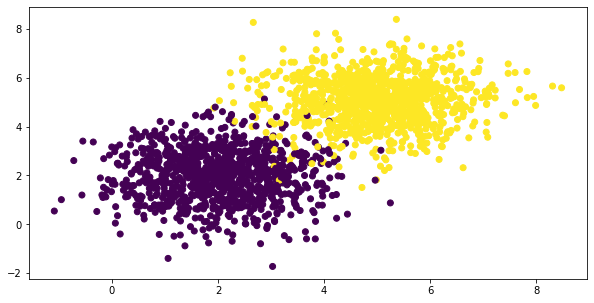

In [23]:
# Define dataset
dataset_name = "SYN"
DataObj = Dataset(dataset_name)
X,Y, n_features = DataObj.make_dataset()
plt.figure(figsize=(10,5))
plt.scatter(X[:,0],X[:,1],c=Y)
plt.show()

In [24]:
# Define hyperparameters
input_size = X.shape[1]
hidden_size = 64
output_size = 1
learning_rate = 0.0005
epochs = 150000
ModelObj = ModelHelper()


In [25]:
# Define layers 
linear_layer1 = CustomLinearLayer(input_size, hidden_size*2)
linear_layer2 = CustomLinearLayer(hidden_size*2, hidden_size)
linear_layer3 = CustomLinearLayer(hidden_size, hidden_size//2)
linear_layer4 = CustomLinearLayer(hidden_size//2, output_size)

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

In [ ]:
# Training loop
for epoch in range(epochs):
    
    # Forward pass 
    
    # Layer 1
    hidden_input  = linear_layer1.forward(X)
    hidden_output = ModelObj.relu(hidden_input)
    
    # Layer 2
    hidden_output2 = linear_layer2.forward(hidden_output)
    hidden_output2 = ModelObj.relu(hidden_output2)
    
    # Layer 3
    hidden_output3 = linear_layer3.forward(hidden_output2)
    hidden_output3 = ModelObj.relu(hidden_output3)
    
    # Layer 4
    output_input     = linear_layer4.forward(hidden_output3)
    predicted_output = ModelObj.sigmoid(output_input)
    
    # Calculate the loss
    loss = Y - predicted_output

    # Backpropagation
    delta_output3  = loss * ModelObj.relu_derivative(predicted_output)
    delta_output2  = ModelObj.grad(linear_layer4, delta_output3, hidden_output3, activation='relu' )
    delta_output   = ModelObj.grad(linear_layer3, delta_output2, hidden_output2, activation='relu' )
    delta_input    = ModelObj.grad(linear_layer2, delta_output , hidden_output , activation='sigmoid' )

    # Update Layers
    linear_layer4 = ModelObj.update_layer(linear_layer4, hidden_output3, delta_output3, X, learning_rate)
    linear_layer3 = ModelObj.update_layer(linear_layer3, hidden_output2, delta_output2, X, learning_rate)
    linear_layer2 = ModelObj.update_layer(linear_layer2, hidden_output , delta_output , X, learning_rate)
    linear_layer1 = ModelObj.update_layer(linear_layer1, X,              delta_input  , X, learning_rate)

    # Calculate error 
    error = 0.5 * torch.mean((Y - predicted_output) ** 2)

    if (epoch + 1) % 5000 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {error}')
    

Epoch [5000/150000], Loss: 0.07103651762008667


In [ ]:
ModelObj.plot_decision_boundary(X, Y)